# Load Data

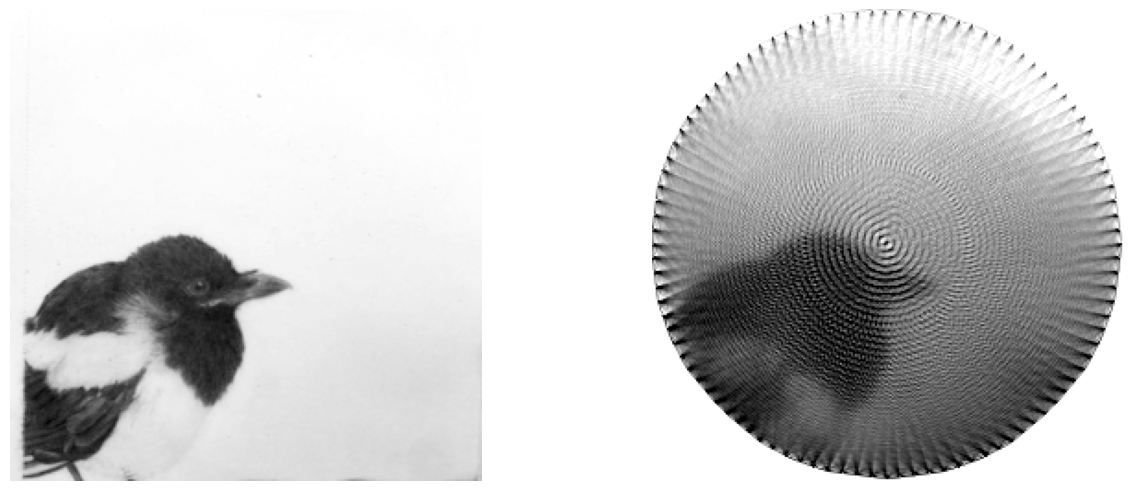

In [2]:
import os

import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from skimage.io import imread
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import to_tensor
from typing import Tuple


class Config:
    DATASET_DIR = "/kaggle/input/stringart-ai-1000/stringart-dataset"
    UNET_PLOT_DIR= "/kaggle/working"
    

class StringArtDataset(Dataset):
    def __init__(self, file_list):
        self.file_list = file_list

        self.images = []
        self.labels = []

        for img_path, label_path in self.file_list:
            img = np.array(imread(img_path))
            label = np.array(imread(label_path))

            self.images.append(to_tensor(img))
            self.labels.append(to_tensor(label))

        self.images = torch.stack(self.images)
        self.labels = torch.stack(self.labels)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


def load_data(input_dir: str, batch_size: int = 64) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """Load the dataset from the specified directory, split it into training, validation, and test sets,
    and return corresponding DataLoaders for each set.

    Parameters
    ----------
    input_dir : str
        The directory path containing the dataset. It should have a `metadata.csv` file and
        subdirectories `images` and `labels` containing the image and label files, respectively.
    batch_size : int, optional
        The batch size for the DataLoader. Default is 64.

    Returns
    -------
    tuple
        A tuple containing three `DataLoader` objects:
        - train_loader (DataLoader): The DataLoader for the training dataset.
        - validation_loader (DataLoader): The DataLoader for the validation dataset.
        - test_loader (DataLoader): The DataLoader for the test dataset.
    """

    df = pd.read_csv(os.path.join(input_dir, "metadata.csv"))
    samples = [
        (os.path.join(input_dir, "images", img_name), os.path.join(input_dir, "labels", label_name))
        for _, (img_name, label_name) in df.iterrows()
    ]

    train_data, temp_data = train_test_split(samples, test_size=0.3, random_state=42)
    validation_data, test_data = train_test_split(temp_data, test_size=0.1, random_state=42)

    train_loader = DataLoader(StringArtDataset(train_data), batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(StringArtDataset(validation_data), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(StringArtDataset(test_data), batch_size=batch_size, shuffle=False)

    return train_loader, validation_loader, test_loader



train_loader, validation_loader, test_loader = load_data(Config.DATASET_DIR, batch_size=16)

batch = next(iter(train_loader))
img, label = batch[0][0], batch[1][0]

image = img.cpu().numpy().transpose(1, 2, 0)
label = label.cpu().numpy().transpose(1, 2, 0)

fig, axs = plt.subplots(1, 2, figsize=[2 * 6.4, 4.8], constrained_layout=True)
cmap = "gray"

axs[0].imshow(image, cmap=cmap)
axs[0].set_axis_off()

axs[1].imshow(label, cmap=cmap)
axs[1].set_axis_off()

fig.show()

# U-Net

In [9]:
import torch
from torch import nn, optim

class DoubleConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv2d, self).__init__()

        self.double_conv2d = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.double_conv2d(x)


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.encoder = nn.ModuleList(
            [
                DoubleConv2d(in_channels, 16),
                DoubleConv2d(16, 32),
                DoubleConv2d(32, 64),
                DoubleConv2d(64, 128),
                DoubleConv2d(128, 256),
            ]
        )

        self.decoder = nn.ModuleList(
            [
                DoubleConv2d(256, 128),
                DoubleConv2d(128, 64),
                DoubleConv2d(64, 32),
                DoubleConv2d(32, 16),
            ]
        )

        self.deconv = nn.ModuleList(
            [
                nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
                nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
                nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
                nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            ]
        )

        self.pool = nn.MaxPool2d((2, 2))
        self.last_layer_conv = nn.Conv2d(in_channels=16, out_channels=out_channels, kernel_size=1, stride=1)

    def forward(self, x):
        stk = []
        for encoder in self.encoder:
            x = encoder(x)
            stk.append(x)
            x = self.pool(x)

        x = stk.pop(-1)
        for index in range(len(self.decoder)):
            encoder_output = stk.pop(-1)
            x = self.deconv[index](x)

            x = torch.cat([encoder_output, x], dim=1)
            x = self.decoder[index](x)

        return torch.sigmoid(self.last_layer_conv(x))

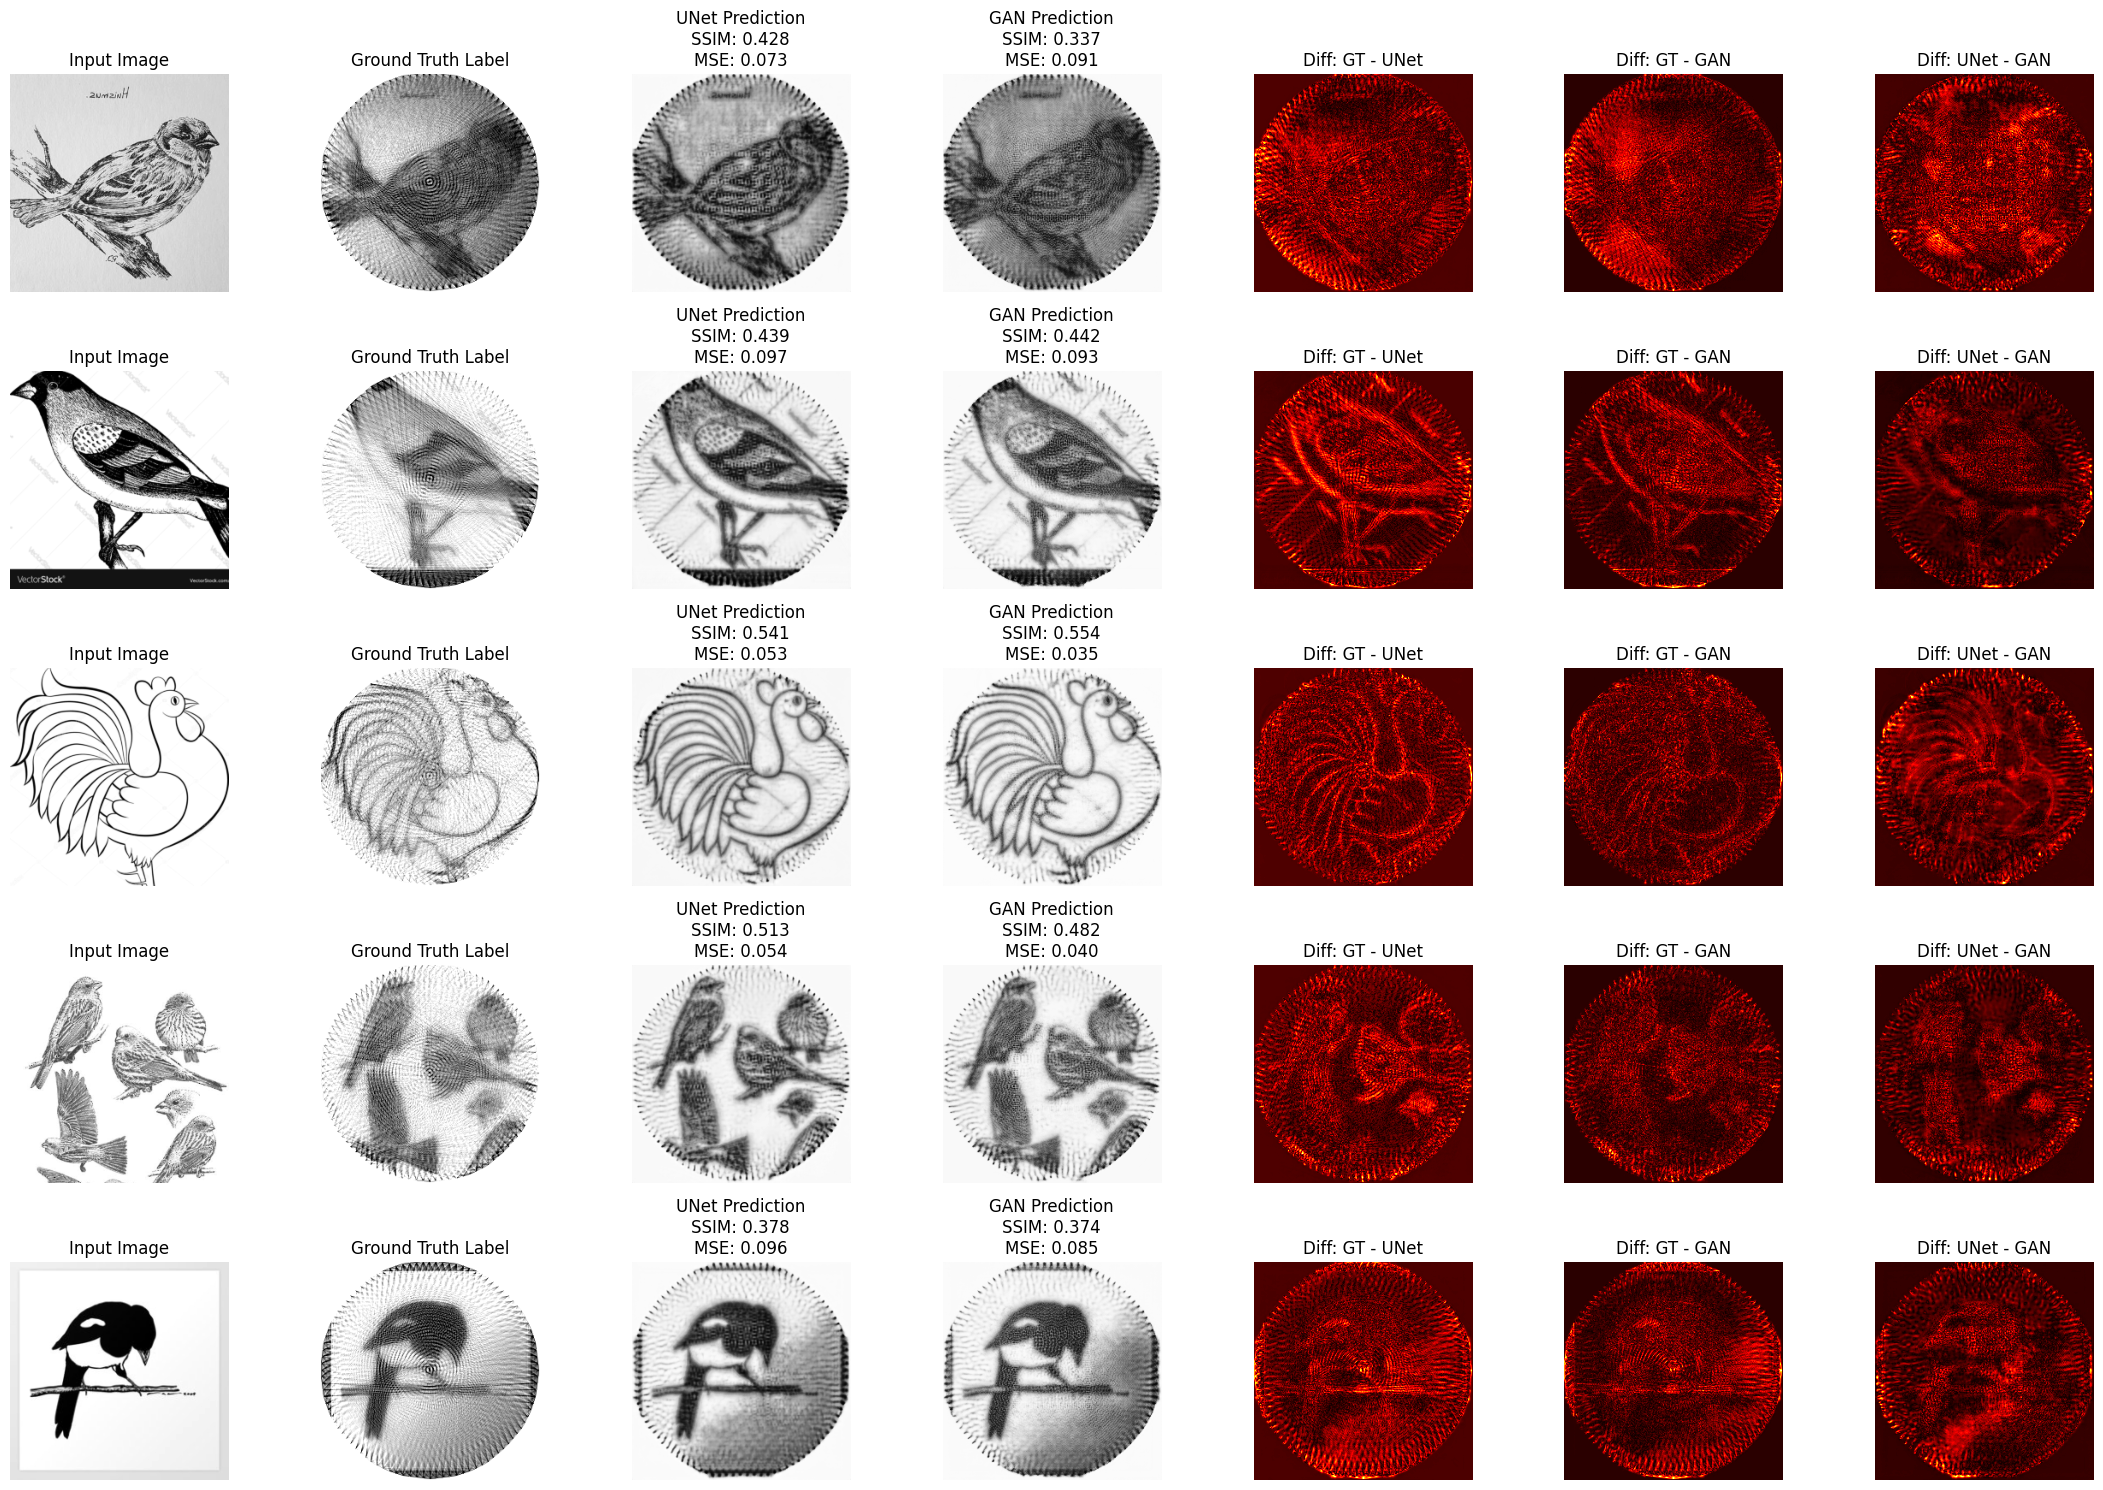

In [10]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim

class Config:
    DATASET_DIR = "/kaggle/input/stringart-ai-1000/stringart-dataset"


def load_models():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    checkpoint_unet = torch.load("/kaggle/input/u-net/pytorch/best_unet/1/best_unet_checkpoint.pth", map_location=device, weights_only=False)
    checkpoint_gan = torch.load("/kaggle/input/bestgan/pytorch/gan-unet/1/best_gan_checkpoint.pth", map_location=device, weights_only=False)

    unet = UNet(1, 1)
    unet.load_state_dict(checkpoint_unet["model_state_dict"])

    gan = UNet(1, 1)
    gan.load_state_dict(checkpoint_gan["generator_state_dict"])

    return unet, gan


def plot_comparative_analysis(test_images_batch, test_labels_batch, unet_outputs, gan_outputs):
    """
    Args:
        test_images_batch (Tensor): shape (N, 1, H, W)
        test_labels_batch (Tensor): shape (N, 1, H, W)
        unet_outputs (Tensor): shape (N, 1, H, W)
        gan_outputs (Tensor): shape (N, 1, H, W)
    """

    test_images_batch = test_images_batch.cpu()
    test_labels_batch = test_labels_batch.cpu()
    unet_outputs = unet_outputs.cpu()
    gan_outputs = gan_outputs.cpu()

    n_images = test_images_batch.size(0)

    fig, axes = plt.subplots(n_images, 7, figsize=(22, 3 * n_images))

    if n_images == 1:
        axes = np.expand_dims(axes, 0)

    for idx in range(n_images):
        input_img = test_images_batch[idx].squeeze().numpy()
        label_img = test_labels_batch[idx].squeeze().numpy()
        unet_pred = unet_outputs[idx].squeeze().numpy()
        gan_pred = gan_outputs[idx].squeeze().numpy()

        # Calculate SSIM and MSE
        ssim_unet = ssim(input_img, unet_pred, data_range=unet_pred.max() - unet_pred.min())
        ssim_gan = ssim(input_img, gan_pred, data_range=gan_pred.max() - gan_pred.min())

        mse_unet = mean_squared_error(input_img.flatten(), unet_pred.flatten())
        mse_gan = mean_squared_error(input_img.flatten(), gan_pred.flatten())

        # Plot Input Image
        axes[idx, 0].imshow(input_img, cmap="gray")
        axes[idx, 0].set_title("Input Image")
        axes[idx, 0].axis("off")

        # Plot Ground Truth Label
        axes[idx, 1].imshow(label_img, cmap="gray")
        axes[idx, 1].set_title("Ground Truth Label")
        axes[idx, 1].axis("off")

        # Plot UNet Prediction
        axes[idx, 2].imshow(unet_pred, cmap="gray")
        axes[idx, 2].set_title(f"UNet Prediction\nSSIM: {ssim_unet:.3f}\nMSE: {mse_unet:.3f}")
        axes[idx, 2].axis("off")

        # Plot GAN Prediction
        axes[idx, 3].imshow(gan_pred, cmap="gray")
        axes[idx, 3].set_title(f"GAN Prediction\nSSIM: {ssim_gan:.3f}\nMSE: {mse_gan:.3f}")
        axes[idx, 3].axis("off")

        # Plot Difference (Label - UNet)
        diff_unet = np.abs(label_img - unet_pred)
        axes[idx, 4].imshow(diff_unet, cmap="hot")
        axes[idx, 4].set_title("Diff: GT - UNet")
        axes[idx, 4].axis("off")

        # Plot Difference (Label - GAN)
        diff_gan = np.abs(label_img - gan_pred)
        axes[idx, 5].imshow(diff_gan, cmap="hot")
        axes[idx, 5].set_title("Diff: GT - GAN")
        axes[idx, 5].axis("off")

        # Plot Difference (UNet - GAN)
        diff_models = np.abs(unet_pred - gan_pred)
        axes[idx, 6].imshow(diff_models, cmap="hot")
        axes[idx, 6].set_title("Diff: UNet - GAN")
        axes[idx, 6].axis("off")

    plt.tight_layout()
    plt.savefig("gan_vs_unet_plot.png")
    plt.show()


def main():
    unet, gan = load_models()
    unet.eval()
    gan.eval()

    _, _, test_loader = load_data(Config.DATASET_DIR)

    test_images = []
    test_labels = []

    for inputs, labels in test_loader:
        for image, label in zip(inputs, labels):
            test_images.append(image)
            test_labels.append(label)

            if len(test_images) == 5:
                break

        if len(test_images) == 5:
            break

    test_images_batch = torch.stack(test_images)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    test_images_batch = test_images_batch.to(device)
    test_labels_batch = torch.stack(test_labels)

    unet = unet.to(device)
    gan = gan.to(device)

    with torch.no_grad():
        unet_outputs = unet(test_images_batch)
        gan_outputs = gan(test_images_batch)

    plot_comparative_analysis(test_images_batch, test_labels_batch, unet_outputs, gan_outputs)


if __name__ == "__main__":
    main()
